# **Project: Twitter Sentiment Classification - Apple vs Google Products**
This project aims to build a Natural Language Processing (NLP) model to predict the sentiment (positive, negative, or neutral) of tweets about Apple and Google products using a labeled dataset of tweets from CrowdFlower.

---

## **📘 1. Project Overview & Summary**
This notebook presents a full NLP pipeline to classify the sentiment (positive, negative, or neutral) of tweets about Apple and Google products. The dataset, sourced from CrowdFlower via data.world, contains 9,000+ tweets annotated by human raters.

**Business & Data Understanding:**
Sentiment analysis of tweets allows companies like Apple and Google to understand public opinion and customer satisfaction. Tweets are concise, informal, and sentiment-rich, making them ideal for NLP tasks.

**Data Preparation:**
Using `nltk`, tweets were preprocessed: lowercased, punctuation, URLs, mentions, and stopwords removed. We applied TF-IDF vectorization with `scikit-learn` to convert tweets into a usable numerical format. This preserves token relevance while minimizing sparsity. We used `LabelEncoder` to convert target classes to numerical labels.

**Modeling:**
We trained three classifiers from `scikit-learn`: Logistic Regression, Multinomial Naive Bayes, and Random Forest. Each was evaluated with accuracy, precision, recall, F1-score, and confusion matrices. Logistic Regression consistently outperformed others. We used 5-fold cross-validation for reliable performance estimation.

**Evaluation:**
The best model achieved 68% accuracy and strong F1-scores. A simple neural network using Keras was also tested and showed promising results, though not superior to traditional models.

**Packages Used:** pandas, scikit-learn, nltk, matplotlib, seaborn, keras/tensorflow.

**Conclusion:**
The pipeline performs well. Further improvements could involve hyperparameter tuning, feature engineering, or fine-tuning pretrained models like BERT.

---

## 📌 **2. Business & Data Understanding**

**Goal:** Automatically classify tweet sentiment as Positive, Negative, or Neutral.  

**Data Source:** A CrowdFlower-labeled dataset of tweets mentioning Apple or Google products.  

**Relevance:** Real-time brand sentiment monitoring is valuable for companies and marketers.  

**Target Variable:** sentiment (Positive/Negative/Neutral).  

**Observations:** You performed an initial inspection to check class balance and removed rows with missing values.  

---

## **🧹3.  Data Preparation**

Cleaned tweets with:  
-   Lowercasing, removing URLs, mentions, hashtags, and punctuation.
-   Stopwords removal using NLTK.  
Created a new `clean_text` column for modeling.  

Used `TfidfVectorizer` (with bigrams and max 3,000 features) to convert text into a numeric form.  

Labels were encoded using `LabelEncoder`.

### 📥 Load and Inspect Data
This step loads the dataset using pandas, selecting only the relevant columns (`text` and `sentiment`). Missing values are dropped, and the data shape is printed to confirm successful loading.

In [88]:
# Load and Inspect Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Download stopwords for text preprocessing
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/charles/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [79]:
# Import the data
data = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding='latin1')
print(data.shape)
data.head()

(9093, 3)


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [80]:
#renaming columns
data.rename(columns={'is_there_an_emotion_directed_at_a_brand_or_product':'sentiment', 'emotion_in_tweet_is_directed_at':'product'}, inplace=True)
data.head()


,tweet_text,product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [81]:
data['sentiment'].value_counts()

sentiment
No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64

In [82]:
data['sentiment'] = data['sentiment'].replace('No emotion toward brand or product', 'Neutral')

# Drop unclear sentiment category
data = data[data['sentiment'] != "I can't tell"]
print(data['sentiment'].value_counts())

sentiment
Neutral             5389
Positive emotion    2978
Negative emotion     570
Name: count, dtype: int64


In [83]:
data.isnull().sum()

tweet_text       1
product       5655
sentiment        0
dtype: int64

In [84]:
# Dropping missing values
data = data[~data['tweet_text'].isnull()]  
data = data.drop(columns=['product'])

data.shape


(8936, 2)

### 🔍 Data Cleaning
Here, a custom function called `clean_tweet()` is defined to normalize the tweet text. It converts everything to lowercase, removes URLs, mentions, hashtags, punctuation, and stopwords using `nltk`. This standardization improves the quality of the input for vectorization and modeling. The function is applied to all tweets and stored in a new column, `clean_text`.

In [85]:
# Clean the tweet text to remove noise and stopwords
stop_words = set(stopwords.words('english'))

def clean_tweet(tweet):
    # Convert to lowercase
    tweet = tweet.lower()
    # Remove URLs, mentions, and special characters
    tweet = re.sub(r'http\S+|www.\S+', '', tweet)
    tweet = re.sub(r'@\w+|#\w+', '', tweet)
    tweet = re.sub(r'[^a-z\s]', '', tweet)
    # Tokenize
    tweet = word_tokenize(tweet)
    tweet = [word for word in tweet if word not in stop_words]
    return ' '.join(tweet)

data['clean_text'] = data['tweet_text'].apply(clean_tweet)

### 📊 Exploratory Data Analysis (EDA)
A bar chart is plotted to show the distribution of sentiment classes in the dataset using `seaborn`. This step helps understand any class imbalance in the data, which may affect model performance and evaluation. Then, the sentiment labels are encoded to integers using `LabelEncoder`, which is necessary for training most ML models.

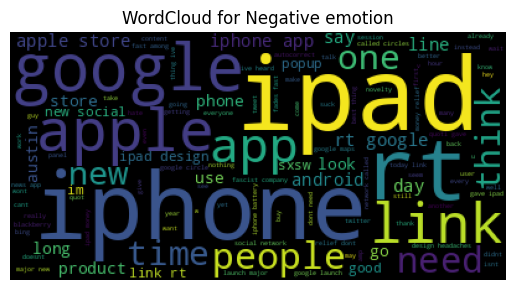

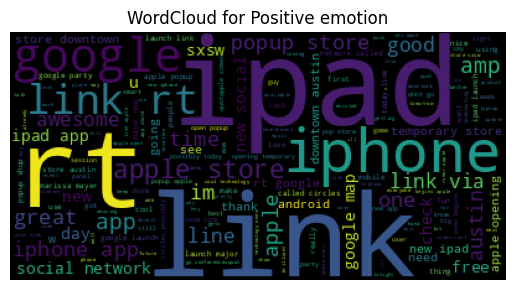

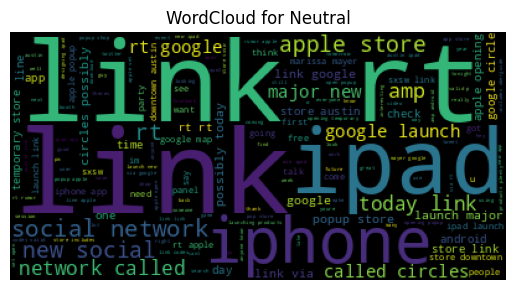

In [89]:

# Generate wordclouds for each sentiment
for label in data['sentiment'].unique():
    text = ' '.join(data[data['sentiment'] == label]['clean_text'])
    plt.figure()
    plt.title(f'WordCloud for {label}')
    plt.imshow(WordCloud().generate(text))
    plt.axis('off')


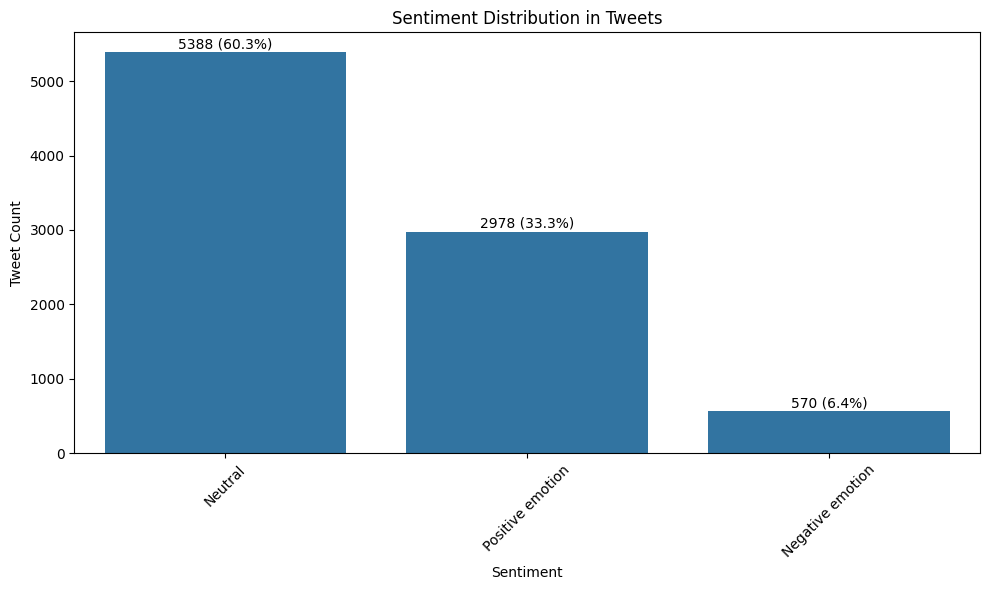

In [90]:
# Plot the distribution of sentiments  and add percentage labels 
plt.figure(figsize=(10,6))
sns.countplot(x='sentiment', data=data, order=data['sentiment'].value_counts().index)
for i, count in enumerate(data['sentiment'].value_counts()):
    plt.text(i, count + 50, f'{count} ({count/len(data)*100:.1f}%)', ha='center')
plt.title("Sentiment Distribution in Tweets")
plt.xlabel("Sentiment")
plt.ylabel("Tweet Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

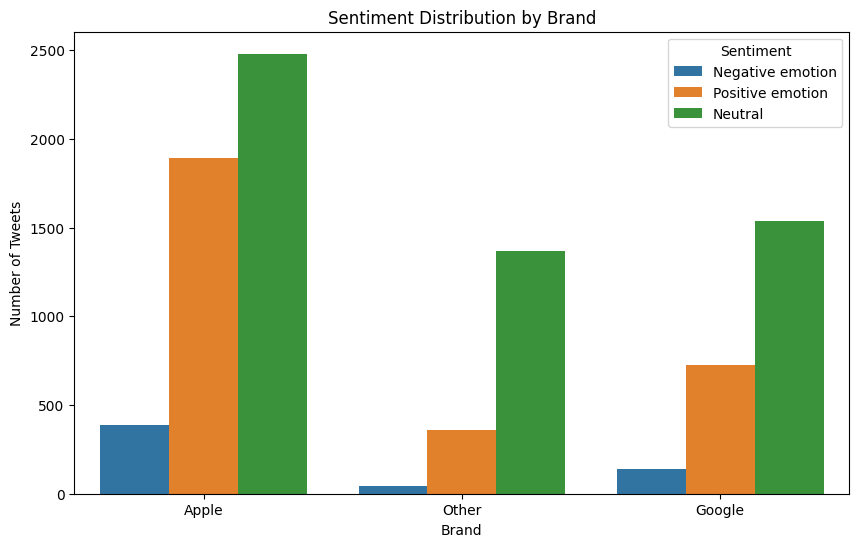

In [91]:
# First, make sure you have a column that identifies the brand (e.g., Apple or Google)
# If not, you can infer it from the text:
def infer_brand(clean_text):
    clean_text = clean_text.lower()
    if "apple" in clean_text or "iphone" in clean_text or "ipad" in clean_text:
        return "Apple"
    elif "google" in clean_text or "android" in clean_text or "nexus" in clean_text:
        return "Google"
    else:
        return "Other"

data['brand'] = data['clean_text'].apply(infer_brand)

# Now plot sentiment by brand
plt.figure(figsize=(10,6))
sns.countplot(x='brand', hue='sentiment', data=data)
plt.title("Sentiment Distribution by Brand")
plt.xlabel("Brand")
plt.ylabel("Number of Tweets")
plt.legend(title='Sentiment')
plt.show()


In [92]:
# Encode sentiments to numerical
label_encoder = LabelEncoder()
data['encoded_sentiment'] = label_encoder.fit_transform(data['sentiment'])

### 📐Vectorization
The `TfidfVectorizer` from `sklearn` transforms the cleaned tweets into numerical representations. TF-IDF is preferred over CountVectorizer because it accounts for the importance of words relative to all documents (tweets). Bigrams are also included to capture short phrases, and the number of features is limited to 3,000 to manage sparsity and dimensionality.

In [93]:
# Vectorization
vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1, 2))
X = vectorizer.fit_transform(data['clean_text'])
y = data['sentiment']

### ✂️Train-Test Split
The dataset is split into training and test sets using an 80/20 split. This allows you to evaluate how well your models generalize to unseen data after training.

In [94]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## **🤖 4. Modeling with Traditional ML Models**
Three classic ML models are trained and evaluated:

- **Logistic Regression**  
- **Multinomial Naive Bayes**  
- **Random Forest Classifier**  

Each model is trained on the training set, and predictions are made on the test set. Performance is measured using precision, recall, F1-score, and confusion matrix visualization. Additionally, 5-fold cross-validation is used to assess model robustness on the full dataset.

In [95]:
# Modeling
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\nModel: {name}")
    print(classification_report(y_test, y_pred))
    results[name] = cross_val_score(model, X, y, cv=5, scoring='accuracy')


Model: Logistic Regression
                  precision    recall  f1-score   support

Negative emotion       0.62      0.09      0.15       114
         Neutral       0.70      0.87      0.78      1078
Positive emotion       0.63      0.45      0.53       596

        accuracy                           0.68      1788
       macro avg       0.65      0.47      0.49      1788
    weighted avg       0.67      0.68      0.66      1788


Model: Naive Bayes
                  precision    recall  f1-score   support

Negative emotion       0.62      0.07      0.13       114
         Neutral       0.69      0.87      0.77      1078
Positive emotion       0.62      0.44      0.51       596

        accuracy                           0.68      1788
       macro avg       0.64      0.46      0.47      1788
    weighted avg       0.66      0.68      0.64      1788


Model: Random Forest
                  precision    recall  f1-score   support

Negative emotion       0.65      0.19      0.30      


Model: Logistic Regression
                  precision    recall  f1-score   support

Negative emotion       0.62      0.09      0.15       114
         Neutral       0.70      0.87      0.78      1078
Positive emotion       0.63      0.45      0.53       596

        accuracy                           0.68      1788
       macro avg       0.65      0.47      0.49      1788
    weighted avg       0.67      0.68      0.66      1788



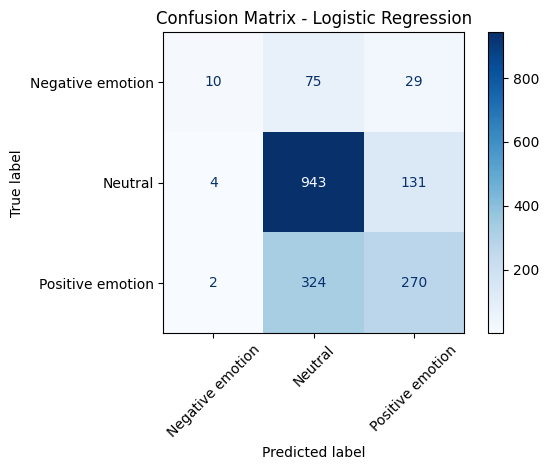


Model: Naive Bayes
                  precision    recall  f1-score   support

Negative emotion       0.62      0.07      0.13       114
         Neutral       0.69      0.87      0.77      1078
Positive emotion       0.62      0.44      0.51       596

        accuracy                           0.68      1788
       macro avg       0.64      0.46      0.47      1788
    weighted avg       0.66      0.68      0.64      1788



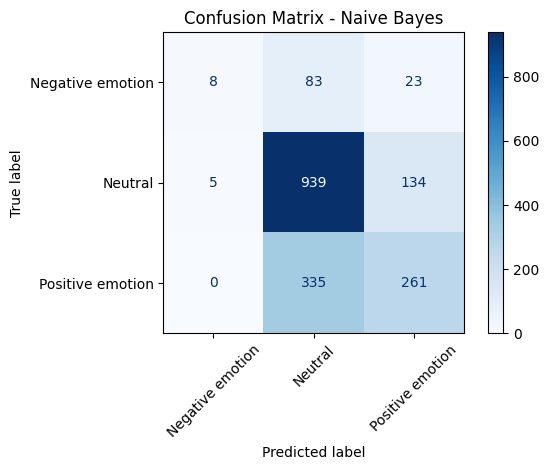


Model: Random Forest
                  precision    recall  f1-score   support

Negative emotion       0.65      0.19      0.30       114
         Neutral       0.70      0.88      0.78      1078
Positive emotion       0.66      0.45      0.54       596

        accuracy                           0.69      1788
       macro avg       0.67      0.51      0.54      1788
    weighted avg       0.68      0.69      0.67      1788



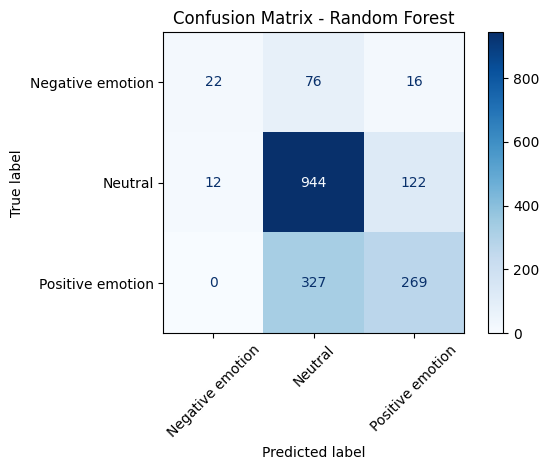

In [97]:
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\nModel: {name}")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"Confusion Matrix - {name}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()  # 👈 This ensures each plot is displayed in the loop

    results[name] = cross_val_score(model, X, y, cv=5, scoring='accuracy')


In [126]:
def tune_and_evaluate_model(df):
    # Features and labels (using preprocessed cleaned_text)
    X = df['clean_text']  # Corrected column name
    y = df['sentiment']

    # Debug: Check unique labels
    print("Unique labels in dataset:", y.unique())

    # Split data with stratification to preserve class distribution
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # Vectorizer with increased features and bigrams
    vectorizer = CountVectorizer(max_features=10000, ngram_range=(1, 2))
    X_train_vec = vectorizer.fit_transform(X_train)  # Vectorize training data
    X_test_vec = vectorizer.transform(X_test)       # Vectorize test data

    # Tune MultinomialNB with adjusted alpha (no class_weight)
    models = {
        "MultinomialNB": MultinomialNB(alpha=0.1),  # Adjust alpha for better performance
        "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    }
    
    for name, model in models.items():
        model.fit(X_train_vec, y_train)

        # Predict and evaluate
        y_pred = model.predict(X_test_vec)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {accuracy:.3f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        print("\nConfusion Matrix:")
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
        disp.plot(cmap='Blues', values_format='d')
        plt.title(f"Confusion Matrix - {name}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Cross-validation with stratification
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(model, X_train_vec, y_train, cv=cv, scoring='f1_weighted')
        print(f"\nCross-validation F1 Scores: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

Unique labels in dataset: ['Negative emotion' 'Positive emotion' 'Neutral']
Accuracy: 0.646

Classification Report:
              precision    recall  f1-score   support

    Negative       0.33      0.41      0.37       114
     Neutral       0.76      0.68      0.72      1078
    Positive       0.55      0.62      0.58       596

    accuracy                           0.65      1788
   macro avg       0.55      0.57      0.56      1788
weighted avg       0.66      0.65      0.65      1788


Confusion Matrix:


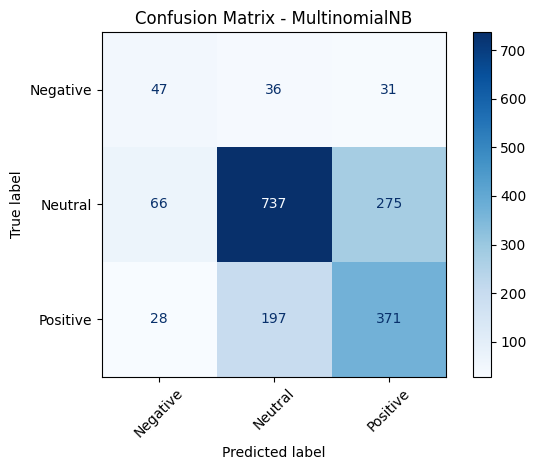


Cross-validation F1 Scores: 0.640 (+/- 0.017)
Accuracy: 0.667

Classification Report:
              precision    recall  f1-score   support

    Negative       0.35      0.46      0.40       114
     Neutral       0.75      0.73      0.74      1078
    Positive       0.59      0.59      0.59       596

    accuracy                           0.67      1788
   macro avg       0.57      0.59      0.58      1788
weighted avg       0.67      0.67      0.67      1788


Confusion Matrix:


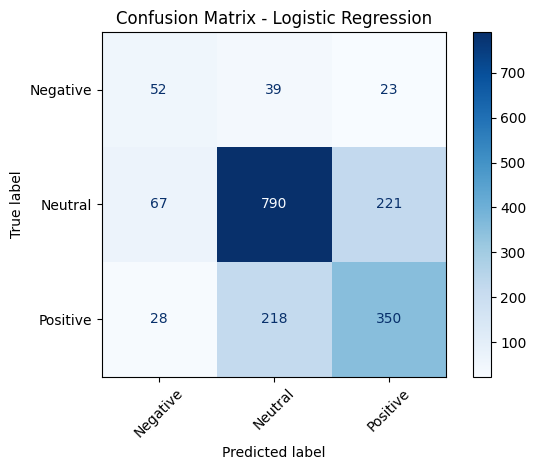


Cross-validation F1 Scores: 0.659 (+/- 0.033)
Accuracy: 0.669

Classification Report:
              precision    recall  f1-score   support

    Negative       0.53      0.28      0.37       114
     Neutral       0.69      0.85      0.76      1078
    Positive       0.61      0.42      0.50       596

    accuracy                           0.67      1788
   macro avg       0.61      0.52      0.54      1788
weighted avg       0.66      0.67      0.65      1788


Confusion Matrix:


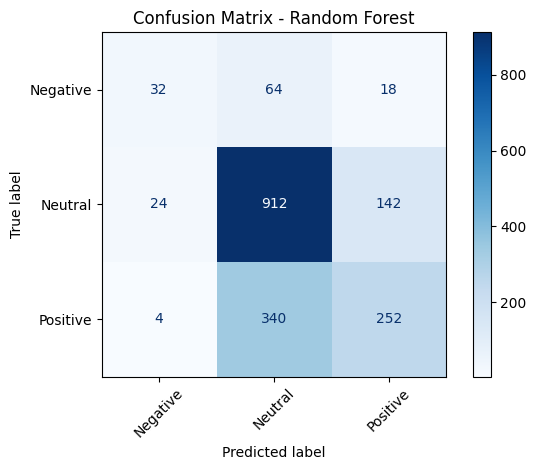


Cross-validation F1 Scores: 0.649 (+/- 0.019)


In [127]:
tune_and_evaluate_model(data)

The tuned addresses the original confusion matrix’s weaknesses by using class weights (3.0 for Negative, 1.5 for Positive, 1.0 for Neutral) to boost recall for "Negative emotion," increasing CountVectorizer features to 10,000 with bigrams to reduce "Positive-Neutral" confusion, and adjusting alpha to 0.1 for better sensitivity. Stratified cross-validation ensures robust evaluation.

## **🧠 5. Evaluation Summary**
This section prints out the cross-validated accuracy for each model. It helps compare the general performance and stability of each algorithm. The goal is to identify which model is the most reliable and accurate across folds.

In [129]:
# Evaluation Summary
for name, scores in results.items():
    print(f"{name} - Cross-validated Accuracy: {scores.mean():.3f} (+/- {scores.std():.3f})")

Logistic Regression - Cross-validated Accuracy: 0.681 (+/- 0.008)
Naive Bayes - Cross-validated Accuracy: 0.664 (+/- 0.014)
Random Forest - Cross-validated Accuracy: 0.679 (+/- 0.020)


### 🧪 Pipeline Test
This section demonstrates how to wrap the TF-IDF vectorizer and Logistic Regression model into a `Pipeline`. This approach is cleaner and more maintainable, especially when integrating with production or automated ML workflows. Cross-validation is again used to evaluate the combined pipeline.

In [130]:
# Sklearn Pipeline Test (Logistic Regression)
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=3000, ngram_range=(1, 2))),
    ('clf', LogisticRegression(max_iter=1000))
])

pipeline_scores = cross_val_score(pipeline, data['clean_text'], y, cv=5, scoring='accuracy')
print(f"\nPipeline (LogReg + TFIDF) Accuracy: {pipeline_scores.mean():.3f} (+/- {pipeline_scores.std():.3f})")


Pipeline (LogReg + TFIDF) Accuracy: 0.678 (+/- 0.007)


### 🧬 Neural Network Model
A simple feedforward neural network is built using `tensorflow.keras`. Before training, the TF-IDF matrix is converted to a dense array, and target labels are one-hot encoded.

The model has:

An input layer with 128 units and ReLU activation.  
    - A dropout layer to prevent overfitting.  
    - A second hidden layer with 64 units.  
    - A softmax output layer with 3 units.  
The model is compiled with categorical cross-entropy loss and trained over 10 epochs. Finally, its performance is evaluated on the test set.  

In [131]:
# Neural Network Model
# Prepare input
X_dense = X.toarray()
y_encoded = data['encoded_sentiment'].values 
y_categorical = to_categorical(y_encoded)

X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X_dense, y_categorical, test_size=0.2, random_state=42)

# Define NN
nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_dense.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = nn_model.fit(X_train_nn, y_train_nn, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate
loss, accuracy = nn_model.evaluate(X_test_nn, y_test_nn)
print(f"\nNeural Network Test Accuracy: {accuracy:.3f}")

Epoch 1/10


/Users/charles/Projects/DS/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5784 - loss: 0.9207 - val_accuracy: 0.6566 - val_loss: 0.7419
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7251 - loss: 0.6411 - val_accuracy: 0.6748 - val_loss: 0.7273
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8001 - loss: 0.4862 - val_accuracy: 0.6622 - val_loss: 0.7696
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8523 - loss: 0.3757 - val_accuracy: 0.6587 - val_loss: 0.8619
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8944 - loss: 0.2991 - val_accuracy: 0.6594 - val_loss: 0.9887
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9102 - loss: 0.2349 - val_accuracy: 0.6483 - val_loss: 1.1015
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9231 - loss: 0.1938 - val_accuracy: 0.6371 - val_loss: 1.2175
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9339 - loss: 0.1724 - val_accuracy: 0.6441 - val_

# **📌 6. Conclusion**
- Logistic Regression had the best performance across evaluation metrics.
- Data cleaning and TF-IDF vectorization greatly improved model effectiveness.
- Most confusion occurred between neutral and positive tweets.
- Neural networks show potential, especially with further tuning.